In [1]:
from iSORTlib import *
import sctour as sct
seed_everything(20)

# Tutorial for SpaRNA velocity

## 1. Load data

### Set directories

In [2]:
st_data_dir = '151674_data.csv'
st_meta_dir = '151674_meta.csv'

### Read and initialize data as AnnData

In [3]:
st_meta = pd.read_csv(st_meta_dir, index_col=0)
st_data = pd.read_csv(st_data_dir, index_col=0)
st_adata = ann.AnnData(st_data.T)
st_adata.obs = st_meta
st_adata.obsm['spatial'] = np.array(st_meta[['ImageRow','ImageCol']])

## 2. Data preprocessing

### Preprocess and filter highly variable genes

In [4]:
sc.pp.highly_variable_genes(st_adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)
st_hvg = st_adata.var['highly_variable'][st_adata.var['highly_variable'] == True].index
st_adata = st_adata[:, list(st_hvg)]
st_obj_hvg = st_adata

### Sort and reassign highly variable genes (to ensure reproducibility)

In [5]:
sorted_hvg = sorted(st_obj_hvg.var_names)
st_obj_hvg = st_obj_hvg[:, sorted_hvg]

### Normalize spatial coordinates

In [6]:
spatial = normalize_spatial_coordinates(st_obj_hvg)

## 3. Inferring RNA velocity by scTour

In [7]:
sc.pp.calculate_qc_metrics(st_obj_hvg, percent_top=None, log1p=False, inplace=True)
tnode = sct.train.Trainer(st_obj_hvg, loss_mode='mse', alpha_recon_lec=0.5, alpha_recon_lode=0.5, n_latent=200)
tnode.train()
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
st_obj_hvg.obs['ptime'] = tnode.get_time()
st_obj_hvg.obs['ptime'] = sct.train.reverse_time(st_obj_hvg.obs['ptime'])
st_obj_hvg.obsm['X_TNODE'] = mix_zs
st_obj_hvg.obsm['X_VF'] = -tnode.get_vector_field(st_obj_hvg.obs['ptime'].values, st_obj_hvg.obsm['X_TNODE'])

Running using GPU.
Epoch 400: 100%|████████████████████████████████████| 400/400 [16:59<00:00,  2.55s/epoch, train_loss=534, val_loss=560]


## 4. Training

Initialize and train model

In [8]:
model, criterion, optimizer = initialize_model(input_features=200, hidden_layers=[64, 16], output_features=2)
train_loader, val_loader = prepare_data(zs, spatial,if_weighted=False)
train_and_validate(model, train_loader, val_loader, optimizer, criterion, 300,  if_weighted=False)

Starting
Done!


## 5.Visualization

... storing 'Layer_Guess' as categorical


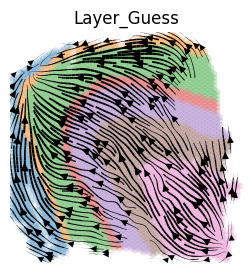

In [9]:
visual=SpaRNAVelocity()
test_velocity=torch.tensor(st_obj_hvg.obsm['X_VF'], dtype=torch.float32)
test_latent=torch.tensor(zs,dtype=torch.float32)
predictions_velocity=visual.compute_velocity(model,test_velocity,test_latent)
visual.plot_velocity(st_obj_hvg,predictions_velocity)